# Using Non Earth dataset

Starting with version 3.0, rio-tiler can work with non-earth based dataset (e.g **Mars** data). In this notebook we'll show how to read such dataset and how to create a simple `non-earth` Tile server.

# Requirements

To be able to run this notebook you'll need the following requirements:
- rio-tiler~=4.0
- ipyleaflet
- matplotlib
- tornado

In [11]:
# !pip install rio-tiler
# !pip install ipyleaflet
# !pip install matplotlib
# !pip install tornado

In [3]:
from matplotlib.pyplot import imshow

from rio_tiler.io import Reader

# In order to fully work, we'll need to build a custom TileMatrixSet
from morecantile import TileMatrixSet
from pyproj import CRS

# For this DEMO we will use this file
src_path = "https://raw.githubusercontent.com/cogeotiff/rio-tiler/main/tests/fixtures/cog_nonearth.tif"

In [4]:
# Let's first try with default
# We should see 3 different warnings here
# - UserWarning: Cannot dertermine bounds in WGS84: There is no existing transformation to WGS84
# - UserWarning: Cannot dertermine minzoom based on dataset informations: We cannot get default Zooms in WebMercator projection
# - UserWarning: Cannot dertermine maxzoom based on dataset informations: We cannot get default Zooms in WebMercator projection
with Reader(src_path) as src:
    print(src.info().json())

ERROR 1: PROJ: proj_create_operations: Source and target ellipsoid do not belong to the same celestial body
ERROR 6: Cannot find coordinate operations from `PROJCRS["Equirectangular EUROPA",BASEGEOGCRS["GCS_EUROPA",DATUM["D_EUROPA",ELLIPSOID["EUROPA_localRadius",1560800,0,LENGTHUNIT["metre",1,ID["EPSG",9001]]]],PRIMEM["Reference_Meridian",0,ANGLEUNIT["degree",0.0174532925199433,ID["EPSG",9122]]]],CONVERSION["unnamed",METHOD["Equidistant Cylindrical (Spherical)",ID["EPSG",1029]],PARAMETER["Latitude of 1st standard parallel",0,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8823]],PARAMETER["Longitude of natural origin",180,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8802]],PARAMETER["False easting",0,LENGTHUNIT["metre",1],ID["EPSG",8806]],PARAMETER["False northing",0,LENGTHUNIT["metre",1],ID["EPSG",8807]]],CS[Cartesian,2],AXIS["easting",east,ORDER[1],LENGTHUNIT["metre",1,ID["EPSG",9001]]],AXIS["northing",north,ORDER[2],LENGTHUNIT["metre",1,ID["EPSG",9001]]]]' to `EPSG:4326'
/Users

{"bounds": [-180.0, -90, 180.0, 90], "minzoom": 0, "maxzoom": 24, "band_metadata": [["b1", {}]], "band_descriptions": [["b1", "IR-9680"]], "dtype": "float32", "nodata_type": "Nodata", "colorinterp": ["gray"], "scale": null, "offset": null, "colormap": null, "overviews": [2], "driver": "GTiff", "nodata_value": -3.4028226550889045e+38, "count": 1, "height": 884, "width": 921}


/Users/vincentsarago/Dev/venv/py39/lib/python3.9/site-packages/morecantile/models.py:162: UserWarning: Could not create coordinate Transformer from input CRS to the given geographic CRSsome methods might not be available.
  warnings.warn(
ERROR 1: PROJ: proj_create_operations: Source and target ellipsoid do not belong to the same celestial body
ERROR 6: Cannot find coordinate operations from `PROJCRS["Equirectangular EUROPA",BASEGEOGCRS["GCS_EUROPA",DATUM["D_EUROPA",ELLIPSOID["EUROPA_localRadius",1560800,0,LENGTHUNIT["metre",1,ID["EPSG",9001]]]],PRIMEM["Reference_Meridian",0,ANGLEUNIT["degree",0.0174532925199433,ID["EPSG",9122]]]],CONVERSION["unnamed",METHOD["Equidistant Cylindrical (Spherical)",ID["EPSG",1029]],PARAMETER["Latitude of 1st standard parallel",0,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8823]],PARAMETER["Longitude of natural origin",180,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8802]],PARAMETER["False easting",0,LENGTHUNIT["metre",1],ID["EPSG",8806]],PARAMET

{"bounds": [-180.0, -90, 180.0, 90], "minzoom": 4, "maxzoom": 6, "band_metadata": [["b1", {}]], "band_descriptions": [["b1", "IR-9680"]], "dtype": "float32", "nodata_type": "Nodata", "colorinterp": ["gray"], "scale": null, "offset": null, "colormap": null, "overviews": [2], "driver": "GTiff", "nodata_value": -3.4028226550889045e+38, "count": 1, "height": 884, "width": 921}


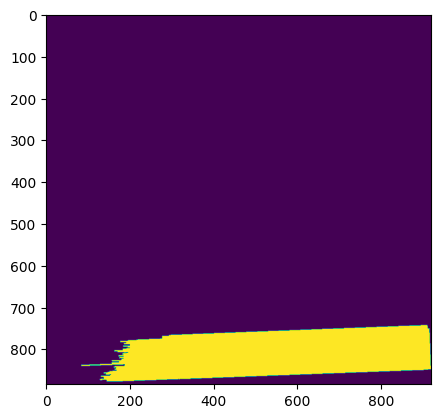

In [5]:
# Create a CUSTOM TMS using the europa ESRI:104915 projection
europa_crs = CRS.from_authority("ESRI", 104915)
europa_tms = TileMatrixSet.custom(
    crs=europa_crs, extent=europa_crs.area_of_use.bounds, matrix_scale=[2, 1],
)

# Use Custom TMS instead of Web Mercator
# We should see 2 different warnings here
# - UserWarning: Could not create coordinate Transformer from input CRS to WGS84: This is from morecantile. It means some methods won't be available but we can ignore. 
# - UserWarning: Cannot dertermine bounds in WGS84: Same as before. the `src.geographic_bounds` property will return default (-180.0, -90.0, 180.0, 90.0)
with Reader(src_path, tms=europa_tms) as src:
    print(src.info().json())
    img = src.preview()
    imshow(img.data_as_image())

Tile(x=27, y=6, z=4)


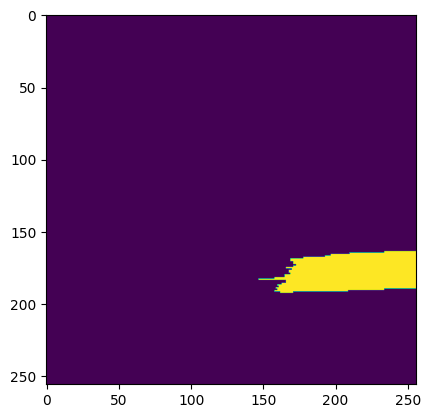

In [6]:
# Read a Tile
from rasterio.warp import transform_bounds

with Reader(src_path, tms=europa_tms) as src:
    # get dataset bounds in TMS's CRS projection
    bounds_in_tms = transform_bounds(src.crs, europa_tms.rasterio_crs, *src.bounds)
    tile = src.tms._tile(bounds_in_tms[0], bounds_in_tms[1], src.minzoom)
    print(tile)

    img = src.tile(tile.x, tile.y, tile.z)
    imshow(img.data_as_image())

## Tile Server

#### Requirements
- tornado

In [12]:
from ipyleaflet import (
    Map,
    TileLayer,
    projections
)

In [13]:
import json
from concurrent import futures

from tornado import web
from tornado import gen
from tornado.httpserver import HTTPServer
from tornado.concurrent import run_on_executor

from rio_tiler.io import Reader
from rio_tiler.errors import TileOutsideBounds
from rio_tiler.profiles import img_profiles

from pyproj import CRS
from morecantile import TileMatrixSet

# Create a CUSTOM TMS using the europa ESRI:104915 projection
europa_crs = CRS.from_authority("ESRI", 104915)
europa_tms = TileMatrixSet.custom(
    crs=europa_crs, extent=europa_crs.area_of_use.bounds, matrix_scale=[2, 1],
)

class TileServer:
    def __init__(self, src_path):
        """Initialize Tornado app."""
        self.server = None
        self.app = web.Application([
            (r"^/tiles/(\d+)/(\d+)/(\d+)", TileHandler, {"url": src_path}),
        ])

    def start(self):
        """Start tile server."""
        self.server = HTTPServer(self.app)
        self.server.listen(8080)
  
    def stop(self):
        """Stop tile server."""
        if self.server:
            self.server.stop()


class TileHandler(web.RequestHandler):
    """Tile requests handler."""

    executor = futures.ThreadPoolExecutor(max_workers=16)

    def initialize(self, url):
        """Initialize tiles handler."""
        self.url = url

    @run_on_executor
    def _get_tile(self, z, x, y):

        try:
            with Reader(self.url, tms=europa_tms) as src:
                data = src.tile(x, y, z)
        except TileOutsideBounds:
            raise web.HTTPError(404)

        image = data.post_process(in_range=((0, 0.5),))

        prof = img_profiles.get("PNG", {})
        return image.render(img_format="PNG", **prof)

    @gen.coroutine
    def get(self, z, x, y):
        """Retunrs tile data and header."""
        self.set_header("Access-Control-Allow-Origin", "*")
        self.set_header("Access-Control-Allow-Methods", "GET")
        self.set_header("Content-Type", "image/png")
        self.set_header("Cache-Control", "no-store, no-cache, must-revalidate")
        res = yield self._get_tile(int(z), int(x), int(y))
        self.write(res)


ts = TileServer(src_path)
ts.start()

/Users/vincentsarago/Dev/venv/py39/lib/python3.9/site-packages/morecantile/models.py:162: UserWarning: Could not create coordinate Transformer from input CRS to the given geographic CRSsome methods might not be available.
  warnings.warn(


In [14]:
bounds = (129.36834223297478, 13.985559117409744, 138.90253908503576, 23.13673177454536)

m = Map(
    center=(
        (bounds[1] + bounds[3]) / 2,
        (bounds[0] + bounds[2]) / 2
    ),
    zoom=4,
    basemap={},
    crs=projections.EPSG4326,  # HACK: the europa TMS is in degree and covers -180, -90, 180, 90 like the WGS84
)

layer = TileLayer(
    url="http://127.0.0.1:8080/tiles/{z}/{x}/{y}",
    min_zoom=4,
    max_zoom=6,
    opacity=1,
)
m.add_layer(layer)
m

Map(center=[18.56114544597755, 134.13544065900527], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [15]:
ts.stop()